# Decode inspector

In [1]:
%reload_ext autoreload
%autoreload 2

In [23]:
import spyglass as nd
import pandas as pd
import os
# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from spyglass.common import (Session, IntervalList,IntervalPositionInfo,
                             LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common.common_interval import _intersection

#from spyglass.decoding.clusterless import (UnitMarks,
#                                           UnitMarkParameters,UnitMarksIndicatorSelection,
#                                          UnitMarksIndicator)
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection
from spyglass.common.common_position import IntervalLinearizedPosition

from spyglass.spikesorting.v0 import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording,SpikeSortingRecordingSelection)

from spyglass.shijiegu.load import load_epoch_data, load_decode
# Here are the analysis tables specific to Shijie Gu
from spyglass.shijiegu.Analysis_SGU import (TrialChoice,
                                   TrialChoiceReplay,
                                   RippleTimes,
                                   DecodeResultsLinear,get_linearization_map,
                                   find_ripple_times,mua_thresholder,sort_replays,
                                   classify_ripples,classify_ripple_content,
                                   load_everything,MUA,
                                   TetrodeNumber,NotExtendedTrialChoiceReplay,RippleTimesWithDecode,
                                  )

from spyglass.shijiegu.ripple_add_replay import plot_decode_spiking

from spyglass.shijiegu.load import load_epoch_data, load_decode, load_run_sessions

In [8]:
nwb_copy_file_name = "lewis20240109_.nwb"
run_session_ids, run_session_names, pos_session_names = load_run_sessions(nwb_copy_file_name)

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
lewis20240109_ 1         01_Rev2Sleep1  pos 0 valid ti
lewis20240109_ 2         02_Rev2Session pos 1 valid ti
lewis20240109_ 3         03_Rev2Sleep2  pos 2 valid ti
lewis20240109_ 4         04_Rev2Session pos 3 valid ti
lewis20240109_ 5         05_Rev2Sleep3  pos 4 valid ti
lewis20240109_ 6         06_Rev2Session pos 5 valid ti
lewis20240109_ 7         07_Rev2Sleep4  pos 6 valid ti
lewis20240109_ 8         08_Rev2Session pos 7 valid ti
lewis20240109_ 9         09_Rev2Sleep5  pos 8 valid ti
 (Total: 9)



In [9]:
epoch_num = 0
session_name = run_session_names[epoch_num]
pos_name = pos_session_names[epoch_num]

In [19]:
# 1. load ripples
try:
    ripple_times = pd.DataFrame((RippleTimesWithDecode & 
                                     {'nwb_file_name': nwb_copy_file_name, 'interval_list_name': session_name}).fetch1('ripple_times'))
except:
    ripple_times = pd.read_pickle((RippleTimesWithDecode & 
                                       {'nwb_file_name': nwb_copy_file_name, 'interval_list_name': session_name}).fetch1('ripple_times'))

In [52]:
# 2. load decode
encoding_set = "2Dheadspeed_above_4"
decoder_lk = "default_decoding_gpu_4armMaze_W20msO10ms"
decoder_ss = "default_decoding_gpu_4armMaze"

key_lk = {'nwb_file_name': nwb_copy_file_name,
          "encoding_set":encoding_set,"interval_list_name": session_name,
          "classifier_param_name": decoder_lk}

key_ss = {'nwb_file_name': nwb_copy_file_name,
          "encoding_set":encoding_set,"interval_list_name": session_name,
          "classifier_param_name": decoder_ss}

print(DecodeResultsLinear & key_lk)
print(DecodeResultsLinear & key_ss)

# load statescript decoder
decode_ss = load_decode(nwb_copy_file_name, session_name, key_ss["classifier_param_name"], encoding_set)
# load lk decoder
decode_lk = load_decode(nwb_copy_file_name, session_name, key_lk["classifier_param_name"], encoding_set)

*nwb_file_name *interval_list *classifier_pa *encoding_set  posterior 
+------------+ +------------+ +------------+ +------------+ +--------+
lewis20240109_ 02_Rev2Session default_decodi 2Dheadspeed_ab =BLOB=    
 (Total: 1)

*nwb_file_name *interval_list *classifier_pa *encoding_set  posterior 
+------------+ +------------+ +------------+ +------------+ +--------+
lewis20240109_ 02_Rev2Session default_decodi 2Dheadspeed_ab =BLOB=    
 (Total: 1)



In [14]:
# need to get theta_df, ripple_df, neural_df
(epoch_name,_,decode_ss,
 head_speed,head_orientation,linear_position_df,
 lfp_df,theta_df,ripple_df,neural_df,_) = load_epoch_data(nwb_copy_file_name,int(session_name[:2]),
                                                          key_ss["classifier_param_name"],
                                                          key_ss["encoding_set"])



epoch name 02_Rev2Session1
epoch_pos_name pos 1 valid times


[2025-05-21 10:54:34,605][WARNING]: Skipped checksum for file with hash: 6cfcf895-2e2b-bb17-c3d1-9422e1618213, and path: /stelmo/nwb/analysis/lewis20240109/lewis20240109_R4LWKFUE59.nwb
[2025-05-21 10:54:34,632][WARNING]: Skipped checksum for file with hash: 6cfcf895-2e2b-bb17-c3d1-9422e1618213, and path: /stelmo/nwb/analysis/lewis20240109/lewis20240109_R4LWKFUE59.nwb
[2025-05-21 10:54:34,641][WARNING]: Skipped checksum for file with hash: 6cfcf895-2e2b-bb17-c3d1-9422e1618213, and path: /stelmo/nwb/analysis/lewis20240109/lewis20240109_R4LWKFUE59.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-nove

In [26]:
# MUA
mua_path=(MUA & {'nwb_file_name': nwb_copy_file_name,
                 'interval_list_name':session_name}).fetch1('mua_trace')
mua_xr = xr.open_dataset(mua_path)
decode_threshold_method = decode_options["decode_threshold_method"]
if decode_threshold_method == 'MUA_0SD':
    mua_threshold=(MUA & {'nwb_file_name': nwb_copy_file_name,
                 'interval_list_name':session_name}).fetch1('mean')
elif decode_threshold_method == 'MUA_05SD':
    mua_threshold = (MUA & {'nwb_file_name': nwb_copy_file_name,
                 'interval_list_name':session_name}).fetch1('mean') + 0.5 * (MUA & {'nwb_file_name': nwb_copy_file_name,
                 'interval_list_name':session_name}).fetch1('sd')
elif decode_threshold_method == 'MUA_M05SD':
    mua_threshold = (MUA & {'nwb_file_name': nwb_copy_file_name,
                 'interval_list_name':session_name}).fetch1('mean') - 0.5 * (MUA & {'nwb_file_name': nwb_copy_file_name,
                 'interval_list_name':session_name}).fetch1('sd')
else:
    mua_threshold = 0

## find tetrodes with signal
groups_with_cell=(SpikeSortingRecordingSelection & {
        'nwb_file_name' : nwb_copy_file_name}).fetch('sort_group_id')
groups_with_cell=np.setdiff1d(groups_with_cell,[100,101])
channel_IDs = list(neural_df.keys())
    
spikeColInd = {}
for g in groups_with_cell:
    spikeColInd_ = np.argwhere(np.isin(channel_IDs,(Electrode() &  {'nwb_file_name' : nwb_copy_file_name,
                                                     'electrode_group_name':str(g)}).fetch('electrode_id'))).ravel()
    spikeColInd[g] = spikeColInd_

In [92]:
ripple_loc =  178
t0t1 = [1704829907.340213,1704829907.3952143]
plottimes = [ripple_times.loc[ripple_loc].start_time,ripple_times.loc[ripple_loc].end_time]

no ripples during this time. None


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/ripple_detection/core.py:47: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  is_start_time = (~series.shift(1).fillna(False)) & series
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/ripple_detection/core.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  is_end_time = series & (~series.shift(-1).fillna(False))


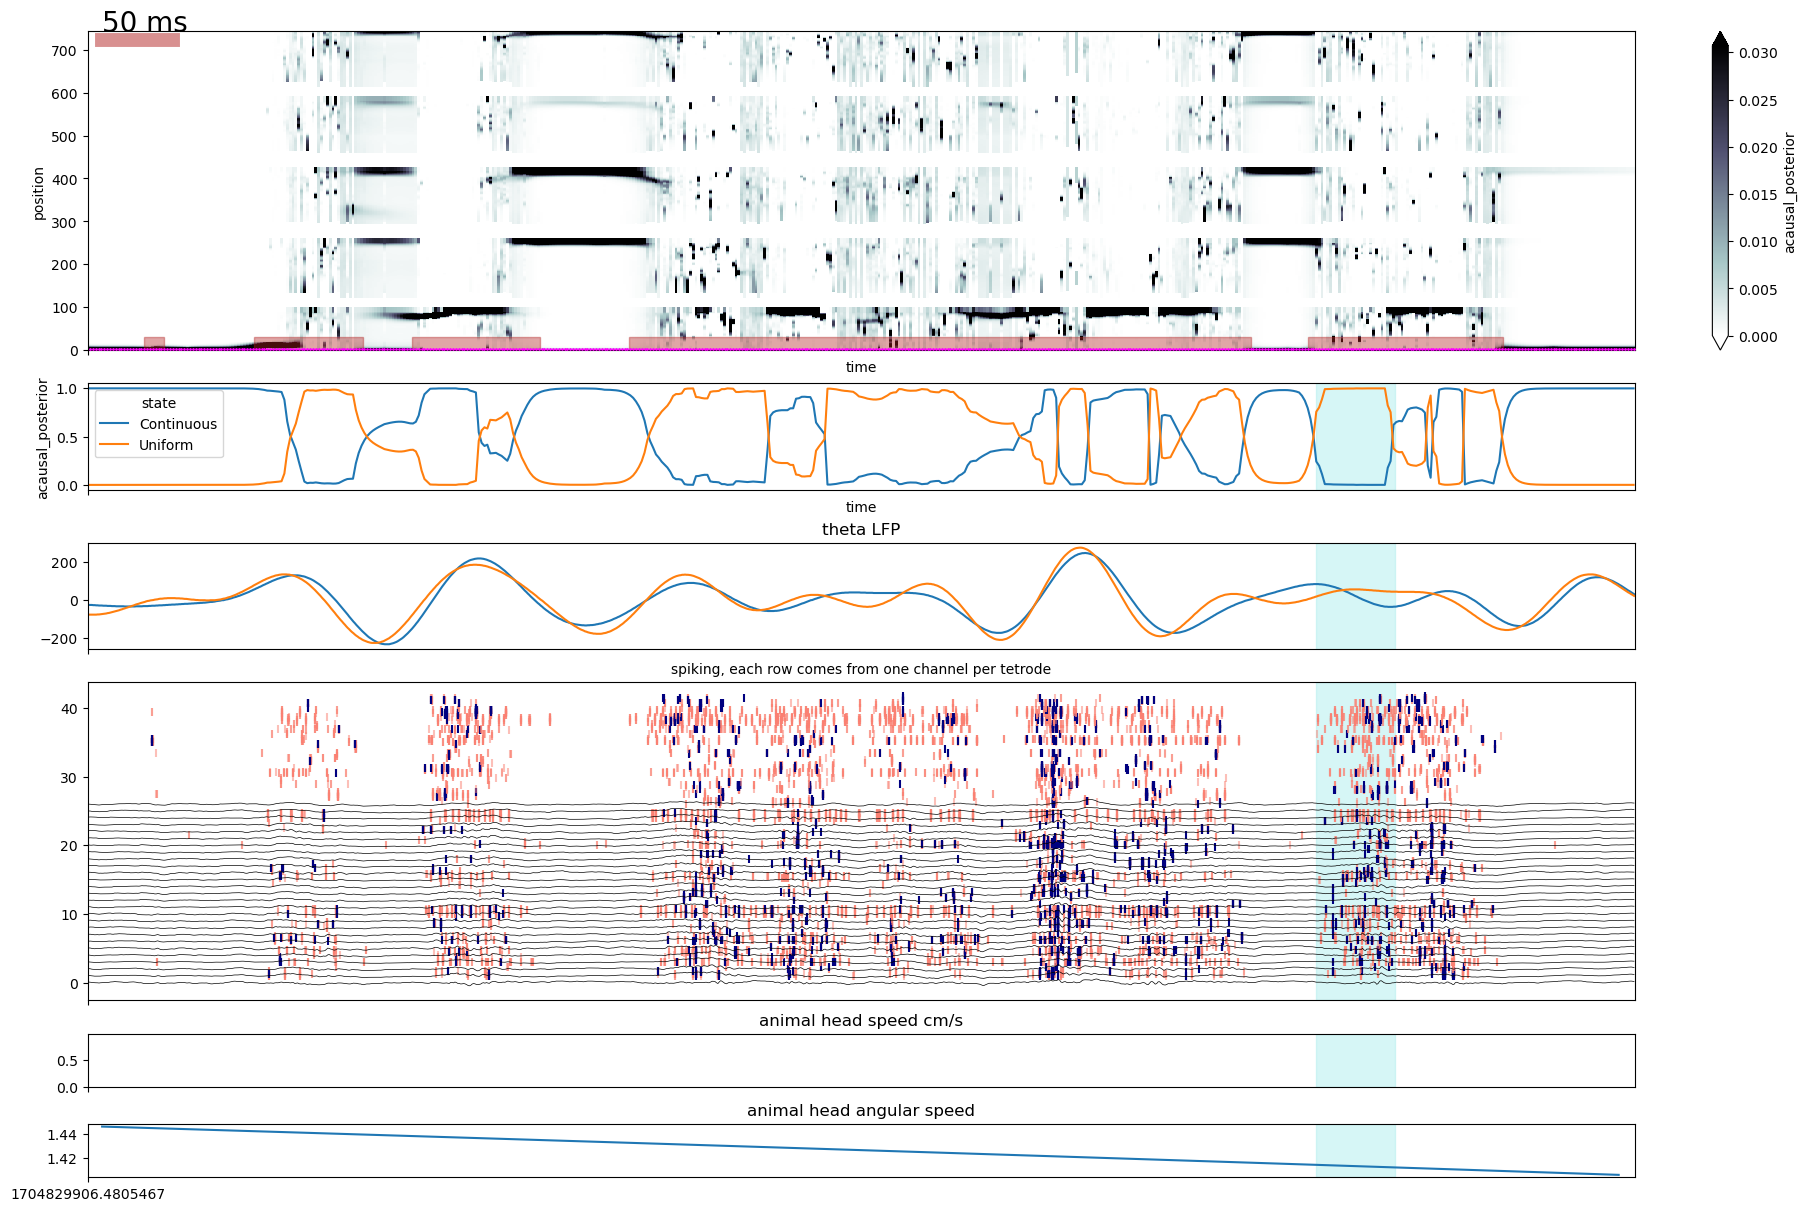

In [93]:
axes = plot_decode_spiking(plottimes,np.array(t0t1).reshape((1,-1)),linear_position_df,decode_ss,lfp_df,theta_df,
                    neural_df,mua_xr,head_speed,head_orientation,
                    ripple_consensus_trace=None,
                    title=None,savefolder=[],savename=None,
                    simple=True,tetrode2ind = spikeColInd,mua_thresh = mua_threshold,
                    causal = False,likelihood = False)

no ripples during this time. None


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/ripple_detection/core.py:47: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  is_start_time = (~series.shift(1).fillna(False)) & series
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/ripple_detection/core.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  is_end_time = series & (~series.shift(-1).fillna(False))


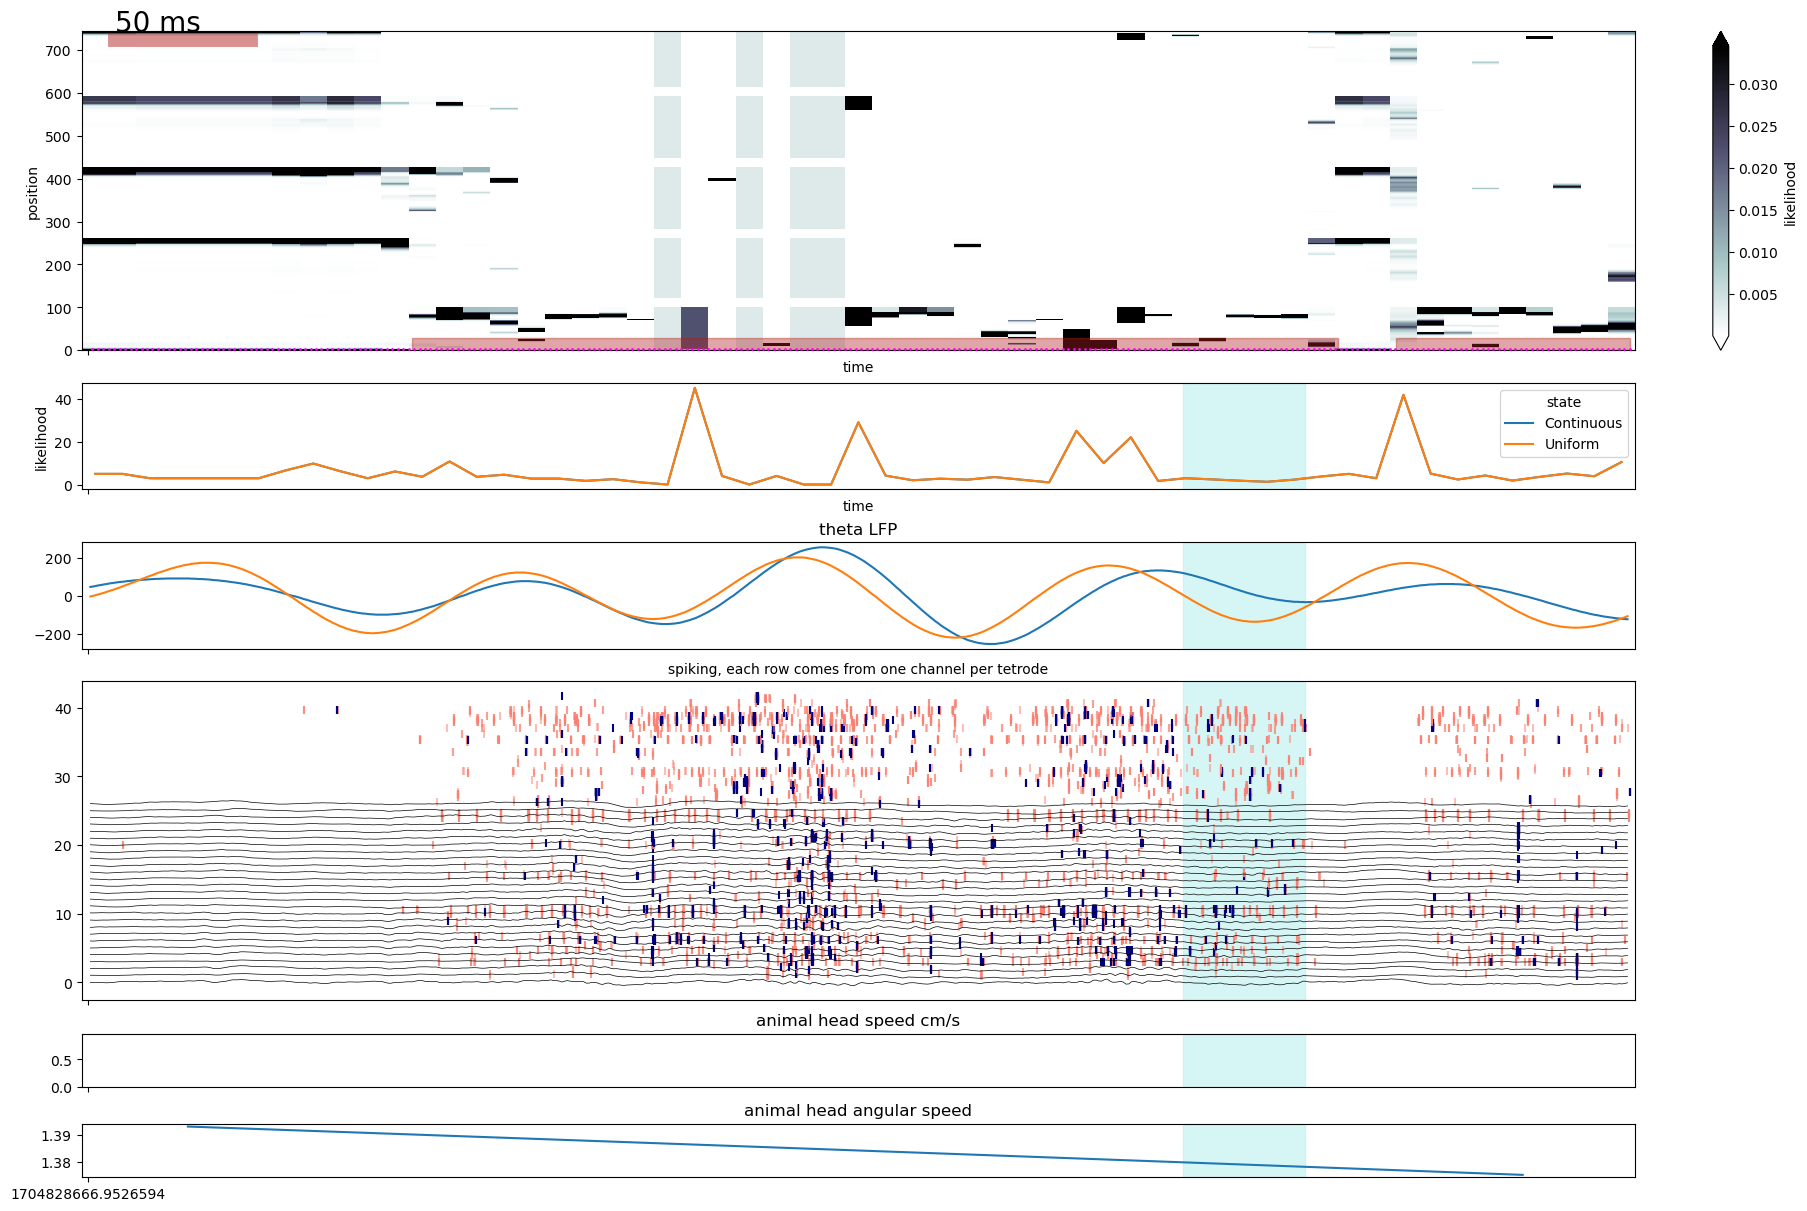

In [79]:
axes = plot_decode_spiking(plottimes,np.array(t0t1).reshape((1,-1)),linear_position_df,decode_lk,lfp_df,theta_df,
                    neural_df,mua_xr,head_speed,head_orientation,
                    ripple_consensus_trace=None,
                    title=None,savefolder=[],savename=None,
                    simple=True,tetrode2ind = spikeColInd,mua_thresh = mua_threshold,
                    causal = False,likelihood = True)